## Step 1: Import packages and data

In [2]:
%matplotlib notebook
# %matplotlib ipympl
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import itertools as it
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm
from hmmlearn import base


import warnings
warnings.filterwarnings('ignore')
desired_width=320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',20)
np.set_printoptions(linewidth=desired_width)
np.set_printoptions(threshold=sys.maxsize)

#### Generate Dataframe of all keypoints from JSON file

In [5]:
keypoints_all = pd.read_json('./Keypoints_All_Ayosh&New.json', orient='records')
new_columns = ['Gesture', 'Sub folder No.', 'Frame No.', 'Joint', 'X', 'Y', 'Probability', 'Depth']
keypoints_all = keypoints_all.reindex(columns = new_columns)
print('keypoints_all shape', keypoints_all.shape)
keypoints_all.head()

keypoints_all shape (686350, 8)


,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Probability,Depth
0,1,1,1,0,648.913696,165.119186,0.935339,0.352941
1,1,1,1,1,650.893982,268.933197,0.867646,0.352941
2,1,1,1,2,576.504761,270.824951,0.772305,0.360784
3,1,1,1,3,556.990112,382.489716,0.813767,0.360784
4,1,1,1,4,554.818665,494.189514,0.862577,0.325490


#### Generate Dataframe of keypoints 1-7

In [6]:
keypoints_1_7 = keypoints_all[keypoints_all['Joint'].isin(range(1,8))]
print('keypoints_1_7 shape', keypoints_1_7.shape)

keypoints_1_7 shape (192178, 8)


## Step 2: Filter out bad recordings (using OpenPose probability)

#### Check Probability (from OpenPose output) per folder

<IPython.core.display.Javascript object>


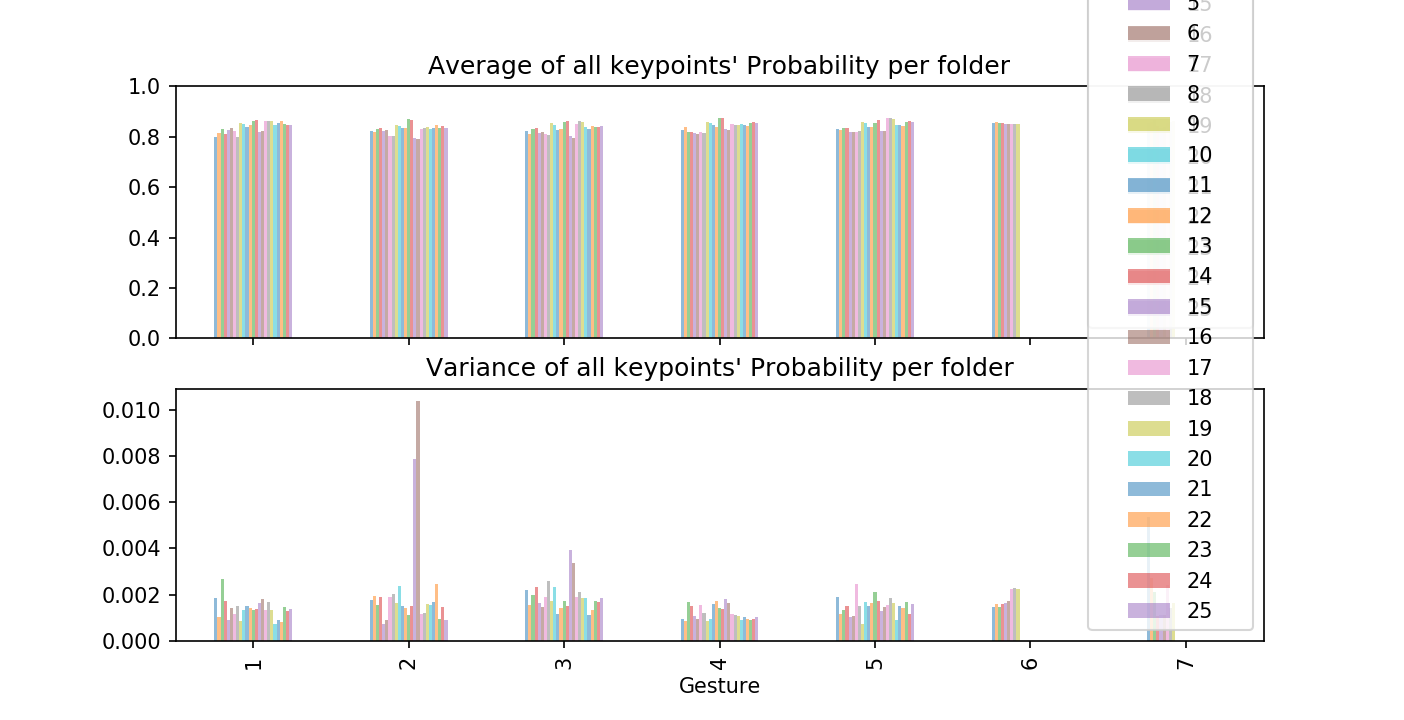

In [7]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=True, alpha=0.5, yticks=np.arange(0, 1.2, 0.2))
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=True, alpha=0.5, yticks=np.arange(0, 0.012, 0.002))

#### Observe distribution of Probability

<IPython.core.display.Javascript object>


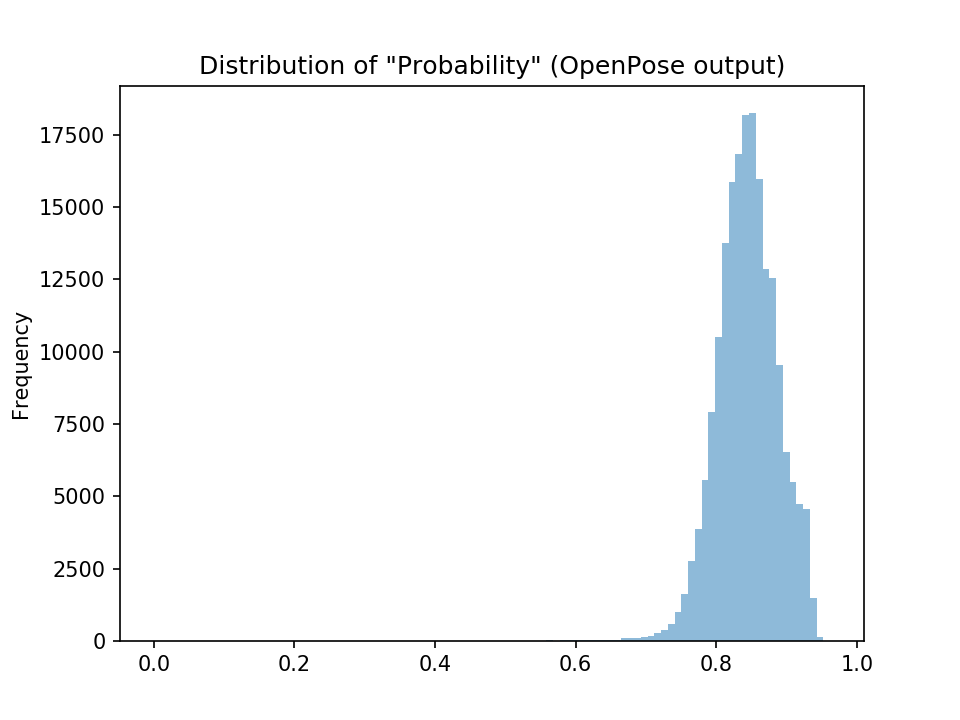

In [8]:
fig = plt.figure()
keypoints_1_7['Probability'].plot.hist(bins=100, title='Distribution of \"Probability\" (OpenPose output)', alpha=0.5)

#### Get Probability value at percentile 1, use it as probability threshold for later data cleaning

In [9]:
prob_threshold = keypoints_1_7['Probability'].quantile(0.01)
print(prob_threshold)

0.7372353673


#### Calculate the percentage of "low probability keypoints" (keypoints probability < probability threshold) per foler

<IPython.core.display.Javascript object>


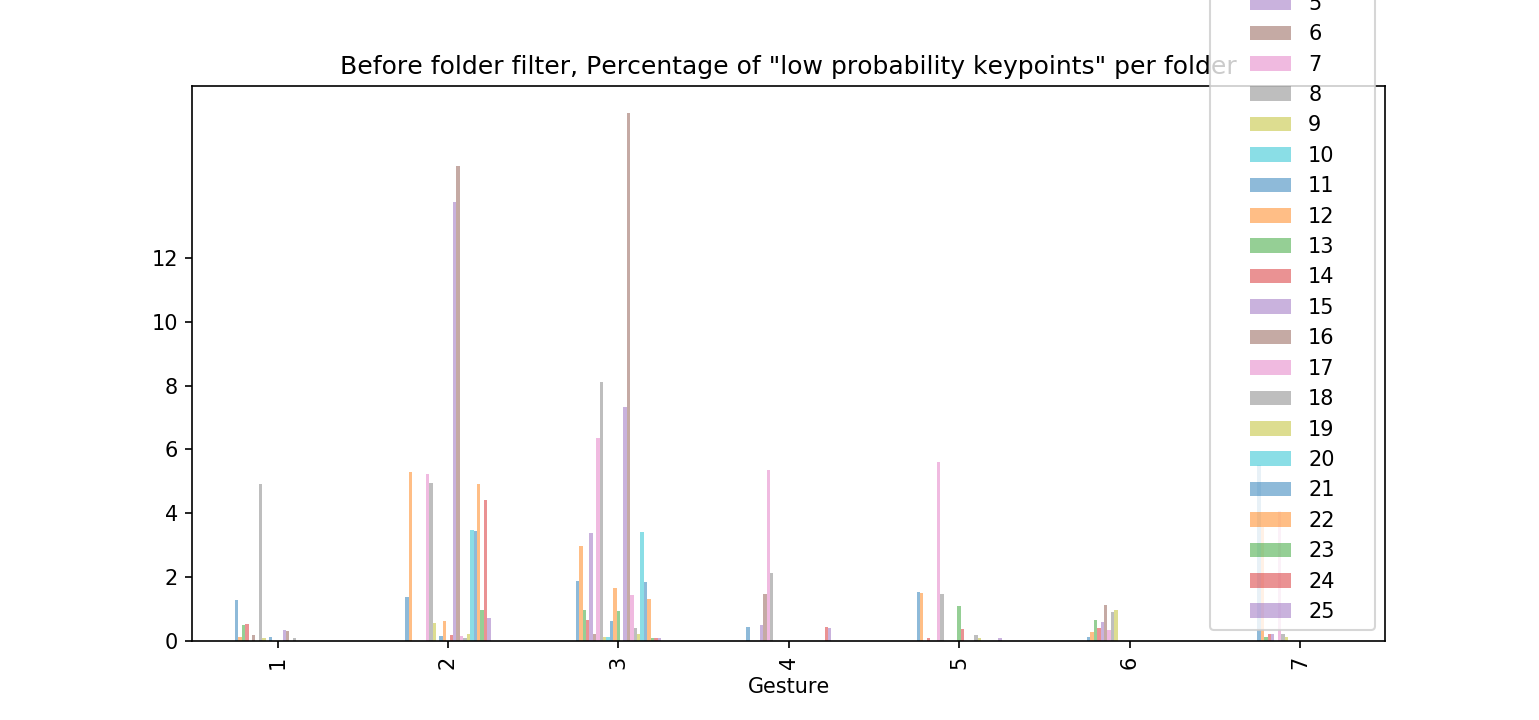

In [10]:
keypoints_1_7_folder_prob_threshold_percent = keypoints_1_7.pivot_table(index = ['Gesture', 'Sub folder No.'], values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100)
keypoints_1_7.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100).plot.bar(title='Before folder filter, Percentage of \"low probability keypoints\" per folder', legend=True, alpha=0.5, yticks=np.arange(0, 13, 2))

#### Filter the folders and keey only the folders has less than 8 percent of "low probability keypoints" 

In [11]:
low_prob_keypoints_percentage_threshold = 8
keypoints_1_7_folder_filtered_index = keypoints_1_7_folder_prob_threshold_percent[keypoints_1_7_folder_prob_threshold_percent['Probability'] < low_prob_keypoints_percentage_threshold].index.tolist()
keypoints_1_7_folder_filtered = keypoints_1_7[keypoints_1_7[['Gesture','Sub folder No.']].apply(lambda x:(x[0],x[1]) in keypoints_1_7_folder_filtered_index, axis=1)]

print('keypoints_1_7_filtered shape', keypoints_1_7_folder_filtered.shape)

keypoints_1_7_filtered shape (188391, 8)


<IPython.core.display.Javascript object>


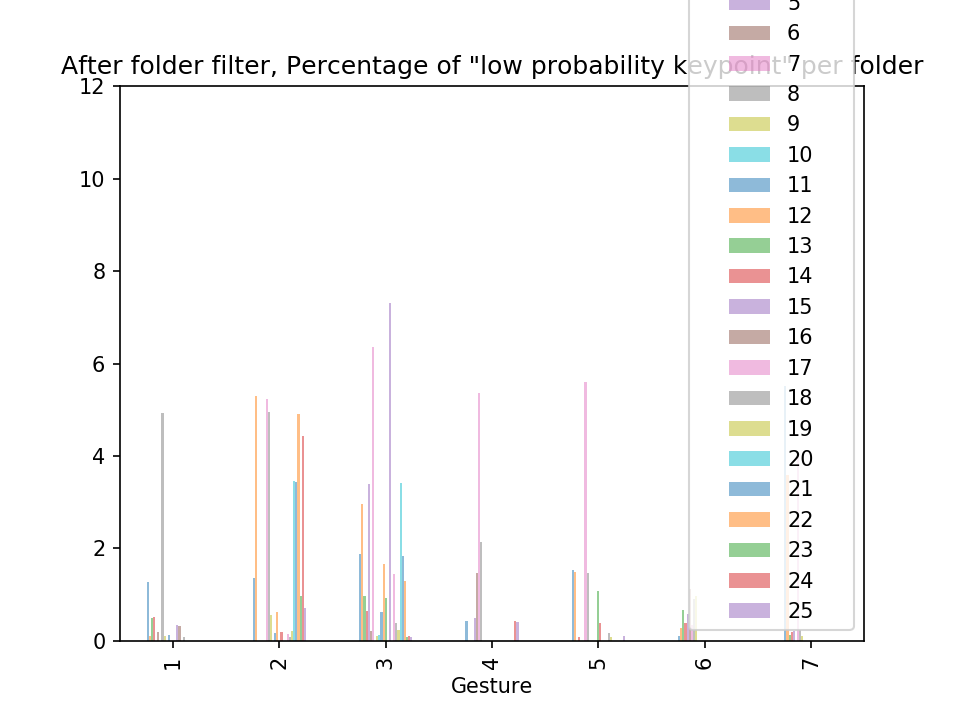

In [12]:
keypoints_1_7_folder_filtered.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100).plot.bar(title='After folder filter, Percentage of \"low probability keypoint\" per folder', legend=True, alpha=0.5, yticks=np.arange(0, 13, 2))

<IPython.core.display.Javascript object>


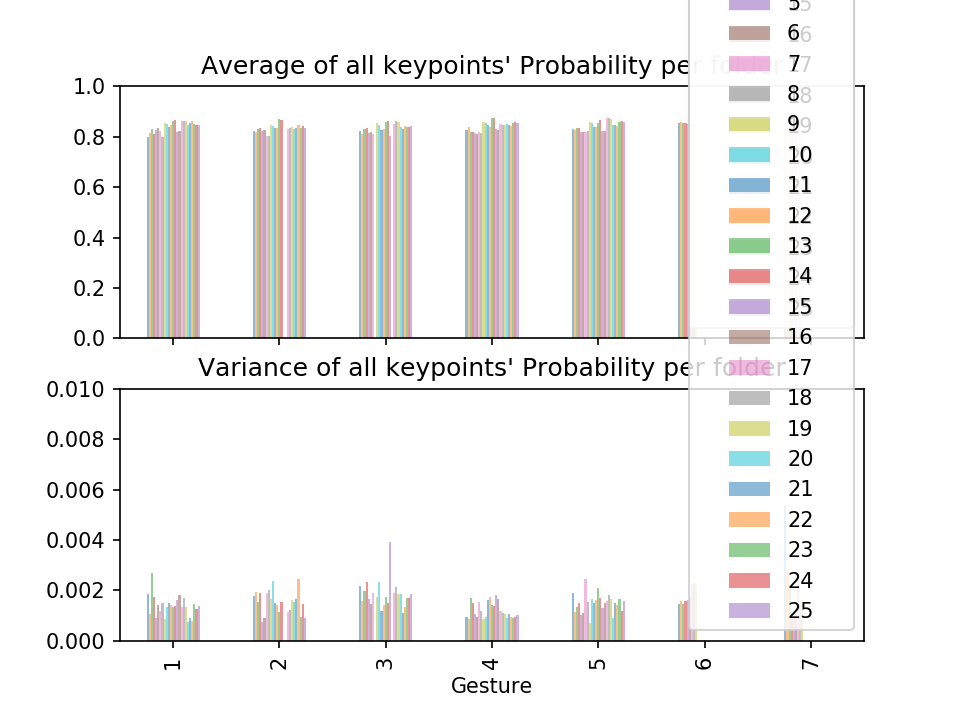

In [13]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=True, alpha=0.5, yticks=np.arange(0, 1.2, 0.2))
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=True, alpha=0.5, yticks=np.arange(0, 0.012, 0.002))

## Step 3: Clean frames (using Weighted Moving Average Smoothing)

### 1. Clean OpenPose outputs (X, Y)

#### Check the X values of Joint 3 in all frames, we can see there are 0 values, this also need to be cleaned

In [ ]:
# keypoints_1_7_folder_filtered[keypoints_1_7_folder_filtered['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X').plot.line(alpha=0.5)

#### We use Weighted Moving Average Smoothing to clean the 0 values of X and Y.
#### First, prepare a dataframe with t-1 and t+1 values for each keypoints

In [ ]:
# df = pd.concat([keypoints_1_7_folder_filtered, keypoints_1_7_folder_filtered.shift(7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t-1)', 'Y':'Y(t-1)', 'Probability':'Probability(t-1)'}), keypoints_1_7_folder_filtered.shift(-7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t+1)', 'Y':'Y(t+1)', 'Probability':'Probability(t+1)'})], axis=1)
# df.head(14)

#### Use Weighted Moving Average Smoothing to calculate X_cleaned and Y_cleaned

In [ ]:
# X_cleaned = df.apply(lambda row: (row['X']*row['Probability'] + row['X(t-1)']*row['Probability(t-1)'] + row['X(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['X'], axis=1)
# Y_cleaned = df.apply(lambda row: (row['Y']*row['Probability'] + row['Y(t-1)']*row['Probability(t-1)'] + row['Y(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['Y'], axis=1)

#### Add cleaned X and Y to the original dataframe

In [ ]:
# keypoints_1_7_frame_cleaned = pd.concat([keypoints_1_7_folder_filtered, X_cleaned.rename('X_cleaned'), Y_cleaned.rename('Y_cleaned')], axis=1)
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

#### Recheck the X values of Joint 3 in all frames, we can see no more 0 values

In [ ]:
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X_cleaned').plot.line(alpha=0.5)

#### After data cleaning of OpenPose data, we also need to clean depth data

#### Check the depth value when probability == 0 (aka. X==0 and Y==0)

In [ ]:
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].pivot_table(index = ['Frame No.', 'Joint'], columns = ['Gesture', 'Sub folder No.'], values='Depth').swapaxes(axis1=0, axis2=1)

#### When Probability == 0, it means that the keypoint is occluded. To estimate the depth value, we use Moving Average Smoothing: get average of depth data at t-1 and t+1

In [ ]:
# df = pd.concat([keypoints_1_7_frame_cleaned, keypoints_1_7_frame_cleaned.shift(7)['Depth'].rename('Depth(t-1)'), keypoints_1_7_frame_cleaned.shift(-7)['Depth'].rename('Depth(t+1)')], axis=1)
# Depth_cleaned = df[['Probability', 'Depth', 'Depth(t-1)', 'Depth(t+1)']].apply(lambda x: np.mean((x[2], x[3])) if x[0]==0 else x[1], axis=1)
# keypoints_1_7_frame_cleaned['Depth_cleaned'] = Depth_cleaned
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

### 2. Clean depth from RealSense camera

#### Now check the depth data of one joint (Joint 4 for example) of all gestures, we can see abnormal depth values (noise)

<IPython.core.display.Javascript object>


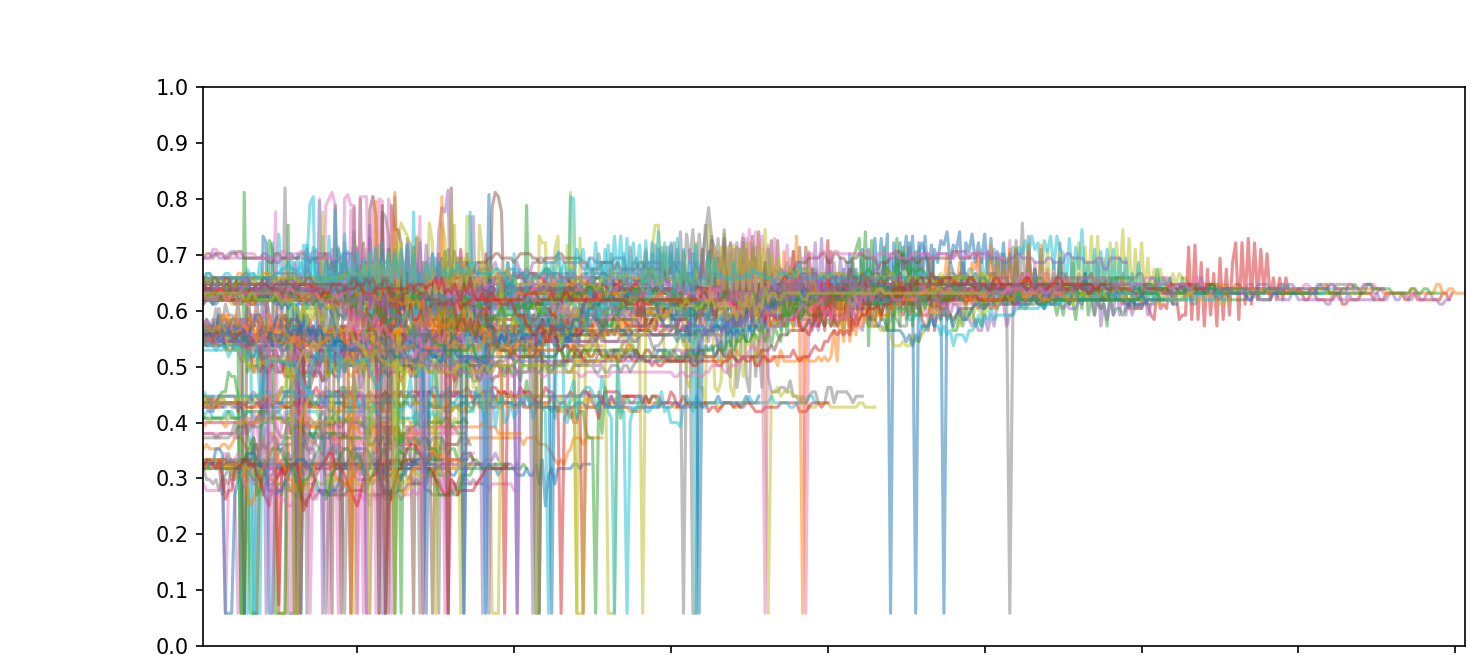

In [14]:
keypoints_1_7_folder_filtered[np.logical_and(keypoints_1_7_folder_filtered['Joint']==4, keypoints_1_7_folder_filtered['Gesture']<8)].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='Depth').plot.line(alpha=0.5, legend=False, yticks=np.arange(0, 1.1, 0.1))

#### Calculate the depth median per Joint of all frames in each Sub folder of each Gesture

In [15]:
Depth_median = keypoints_1_7_folder_filtered.pivot_table(index = ['Gesture', 'Sub folder No.', 'Joint'], values = 'Depth', aggfunc = lambda x: np.median(x)).rename(columns={'Depth':'Depth_median'})
Depth_median.head()

Depth_median
Gesture Sub folder No. Joint              
1       1              1          0.352941
                       2          0.360784
                       3          0.333333
                       4          0.317647
                       5          0.372549

#### Join 'Depth median' into previous keypoint dataframe, then calculate 'Depth - Depth median'  for each depth value

In [16]:
# Join depth median into previous keypoint dataframe
df = keypoints_1_7_folder_filtered.join(Depth_median, on=['Gesture', 'Sub folder No.', 'Joint'])
# Calculate the gap between depth and depth median for each depth value
df['Depth-Depth_median'] = df['Depth'] - df['Depth_median']
df.head()

,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Probability,Depth,Depth_median,Depth-Depth_median
1,1,1,1,1,650.893982,268.933197,0.867646,0.352941,0.352941,0.000000
2,1,1,1,2,576.504761,270.824951,0.772305,0.360784,0.360784,0.000000
3,1,1,1,3,556.990112,382.489716,0.813767,0.360784,0.333333,0.027451
4,1,1,1,4,554.818665,494.189514,0.862577,0.325490,0.317647,0.007843
5,1,1,1,5,723.442871,266.960022,0.757466,0.372549,0.372549,0.000000


#### Plot the distribution of 'Depth - Depth median' of all depth values

Depth-Depth_median
Gesture Sub folder No. Frame No. Joint                    
1       1              1         1                0.000000
                                 2                0.000000
                                 3                0.027451
                                 4                0.007843
                                 5                0.000000

<IPython.core.display.Javascript object>


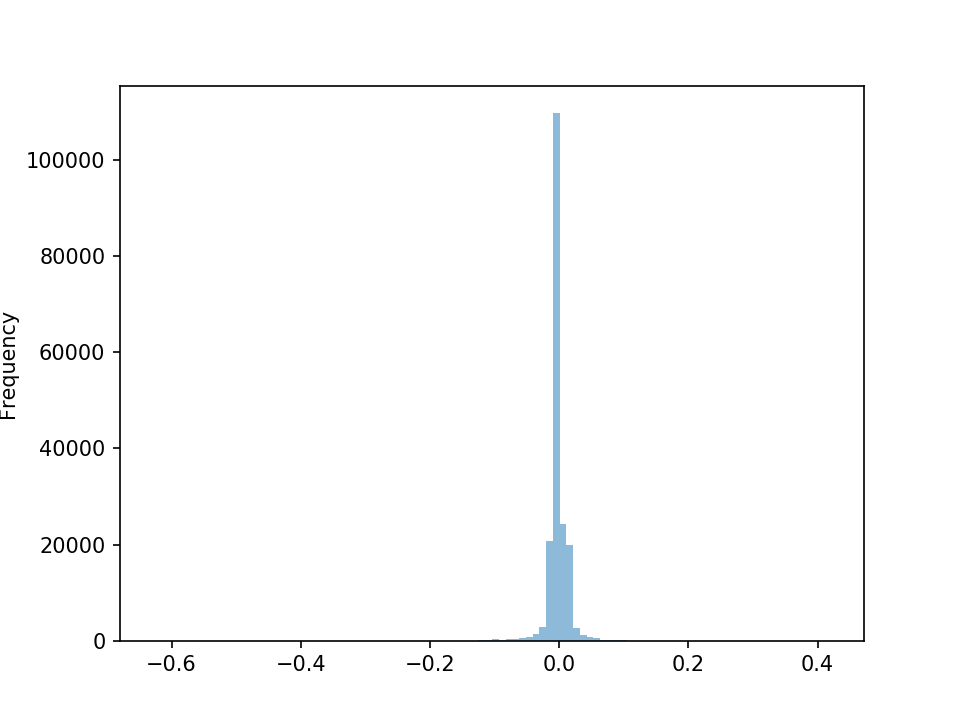

In [17]:
# distribution = df.pivot_table(index = ['Sub folder No.', 'Frame No.'], columns = ['Gesture', 'Joint'], values = 'Depth-Depth_median')
distribution = df.pivot_table(index = ['Gesture', 'Sub folder No.', 'Frame No.', 'Joint'], values = 'Depth-Depth_median')
display(distribution.head())
distribution.plot.hist(bins=100, alpha=0.5, legend=False)

#### Calculate 'Depth - Depth median' at percentile 0.5 and 99.5, use it as confidence interval for later depth cleaning 

In [60]:
# depth_percentile_left = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: x.quantile(0.02)).rename(columns={'Depth - Depth_median':'Depth_confidence_interval_left'})
# depth_percentile_right = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: x.quantile(0.98)).rename(columns={'Depth - Depth_median':'Depth_confidence_interval_right'})
# display(depth_percentile_left.head())
# display(depth_percentile_right.head())
confidence_interval_left = distribution['Depth-Depth_median'].quantile(0.003)
confidence_interval_right = distribution['Depth-Depth_median'].quantile(0.997)
print('confidence_interval_left =', confidence_interval_left)
print('confidence_interval_right =', confidence_interval_right)

confidence_interval_left = -0.1019607843
confidence_interval_right = 0.08235294119999997


#### Calculate the number of "depth out of confidence interval" per Joint

<IPython.core.display.Javascript object>


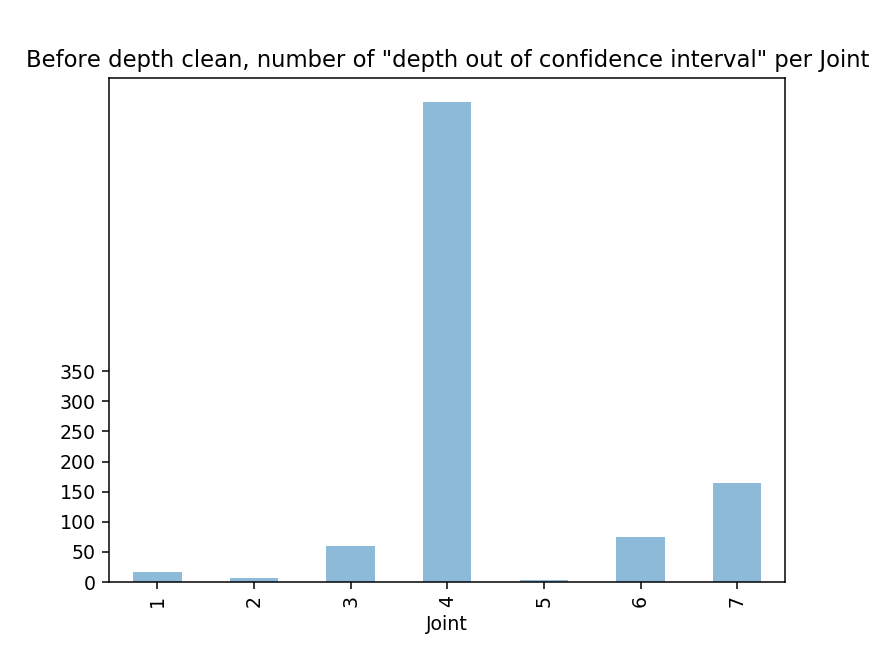

In [61]:
df.pivot_table(index = ['Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: np.count_nonzero(np.logical_or(x<confidence_interval_left, x>confidence_interval_right))).plot.bar(title='Before depth clean, number of \"depth out of confidence interval\" per Joint', legend=False, alpha=0.5, yticks=np.arange(0, 400, 50))

#### Calculate the percentage of "depth out of confidence interval" per Gesture and Sub folder

<IPython.core.display.Javascript object>


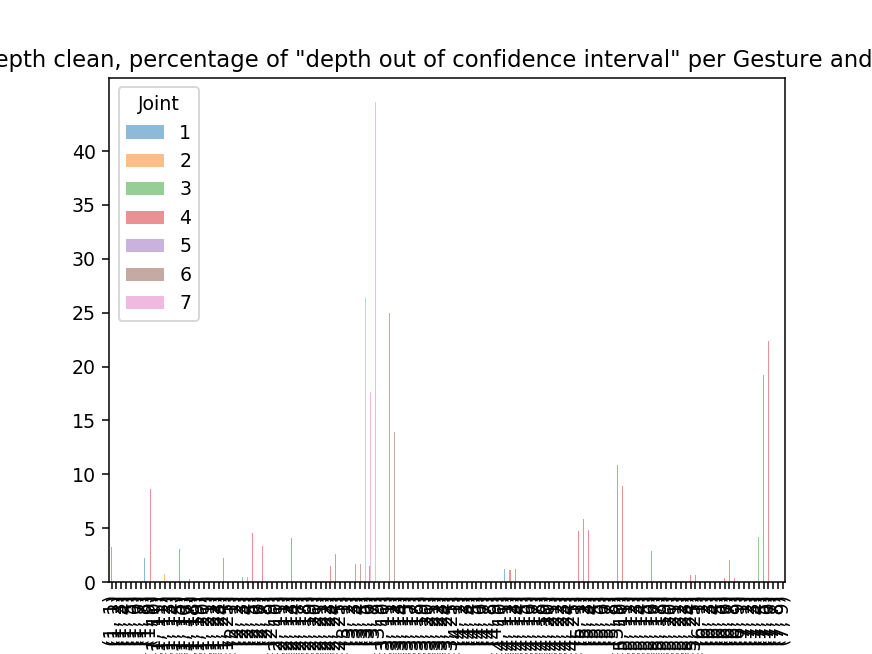

In [62]:
df.pivot_table(index = ['Gesture', 'Sub folder No.'], columns = ['Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: np.count_nonzero(np.logical_or(x<confidence_interval_left, x>confidence_interval_right))/len(x)*100).plot.bar(title='Before depth clean, percentage of \"depth out of confidence interval\" per Gesture and Sub folder', legend=True, alpha=0.5, yticks=np.arange(0, 45, 5))

#### We use Moving Average Smoothing to clean the depth values out of confidence interval.
#### First, prepare a dataframe with t-1 and t+1 values for each keypoints:

In [63]:
# df2 = pd.concat([df, df.shift(7)[['Depth', 'Depth-Depth_median']].rename(columns={'Depth':'Depth (t-1)', 'Depth - Depth_median':'Depth-Depth_median (t-1)'}), df.shift(-7)[['Depth', 'Depth-Depth_median']].rename(columns={'Depth':'Depth (t+1)', 'Depth - Depth_median':'Depth-Depth_median (t+1)'})], axis=1)
df['Depth (t-1)'] = df['Depth'].shift(7)
df['Depth (t+1)'] = df['Depth'].shift(-7)
df.head(14)

,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Probability,Depth,Depth_median,Depth-Depth_median,Depth (t-1),Depth (t+1)
1,1,1,1,1,650.893982,268.933197,0.867646,0.352941,0.352941,0.000000,NaN,0.352941
2,1,1,1,2,576.504761,270.824951,0.772305,0.360784,0.360784,0.000000,NaN,0.360784
3,1,1,1,3,556.990112,382.489716,0.813767,0.360784,0.333333,0.027451,NaN,0.372549
4,1,1,1,4,554.818665,494.189514,0.862577,0.325490,0.317647,0.007843,NaN,0.325490
5,1,1,1,5,723.442871,266.960022,0.757466,0.372549,0.372549,0.000000,NaN,0.372549
6,1,1,1,6,745.062927,374.729736,0.785479,0.333333,0.333333,0.000000,NaN,0.333333
7,1,1,1,7,760.602173,492.263458,0.843681,0.317647,0.317647,0.000000,NaN,0.317647
26,1,1,2,1,650.896179,268.925385,0.864449,0.352941,0.352941,0.000000,0.352941,0.352941
27,1,1,2,2,576.491699,270.830750,0.772756,0.360784,0.360784,0.000000,0.360784,0.372549
28,1,1,2,3,556.973633,382.547607,0.823743,0.372549,0.333333,0.039216,0.360784,0.360784


#### Create a function to do Moving Average Smoothing for depth values out of confidence interval:

In [64]:
def depth_clean(df, times=1):
    for _ in range(times):
        depth_cleaned = df.apply(lambda row: (row['Depth (t-1)'] + row['Depth (t+1)'])/2 if (row['Depth-Depth_median']<confidence_interval_left or row['Depth-Depth_median']>confidence_interval_right) else row['Depth'], axis=1)
#         depth_cleaned = df.apply(lambda row: (row['Depth (t-1)'] + row['Depth'] + row['Depth (t+1)'])/3 if (row['Depth-Depth_median']<confidence_interval_left or row['Depth-Depth_median']>confidence_interval_right) else row['Depth'], axis=1)
        df['Depth'] = depth_cleaned
        df['Depth-Depth_median'] = depth_cleaned - df['Depth_median']
        df['Depth (t-1)'] = depth_cleaned.shift(7)
        df['Depth (t+1)'] = depth_cleaned.shift(-7)
    return df

#### Perform Moving Average Smoothing for 20 times:

In [65]:
keypoints_1_7_depth_cleaned = depth_clean(df.copy(), times=5)

#### After depth clean, recheck the number of "depth out of confidence interval" per Joint

<IPython.core.display.Javascript object>


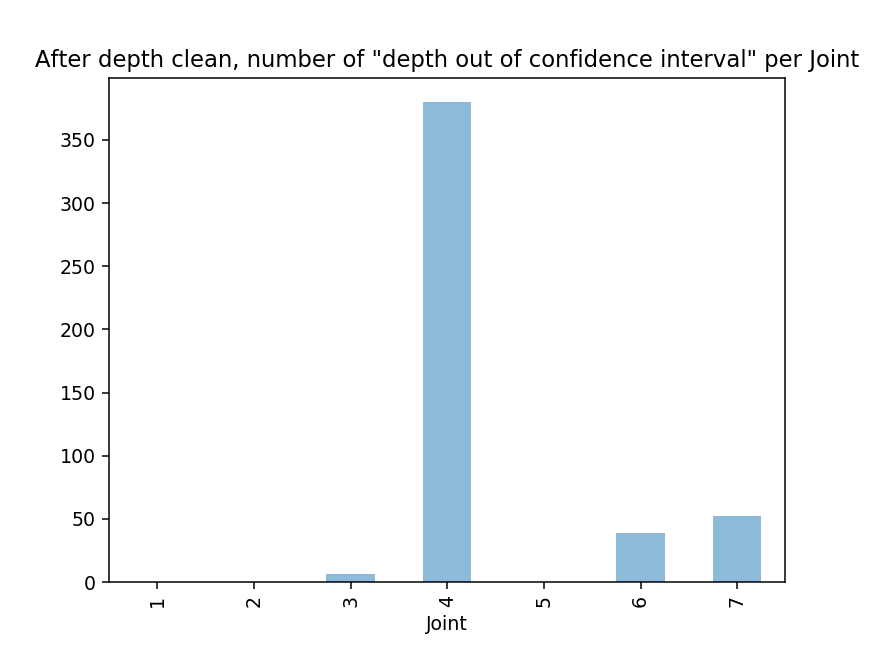

In [66]:
keypoints_1_7_depth_cleaned.pivot_table(index = ['Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: np.count_nonzero(np.logical_or(x<confidence_interval_left, x>confidence_interval_right))).plot.bar(title='After depth clean, number of \"depth out of confidence interval\" per Joint', legend=False, alpha=0.5, yticks=np.arange(0, 400, 50))

#### After depth clean, recheck the percentage of "depth out of confidence interval" per Gesture and Sub folder

<IPython.core.display.Javascript object>


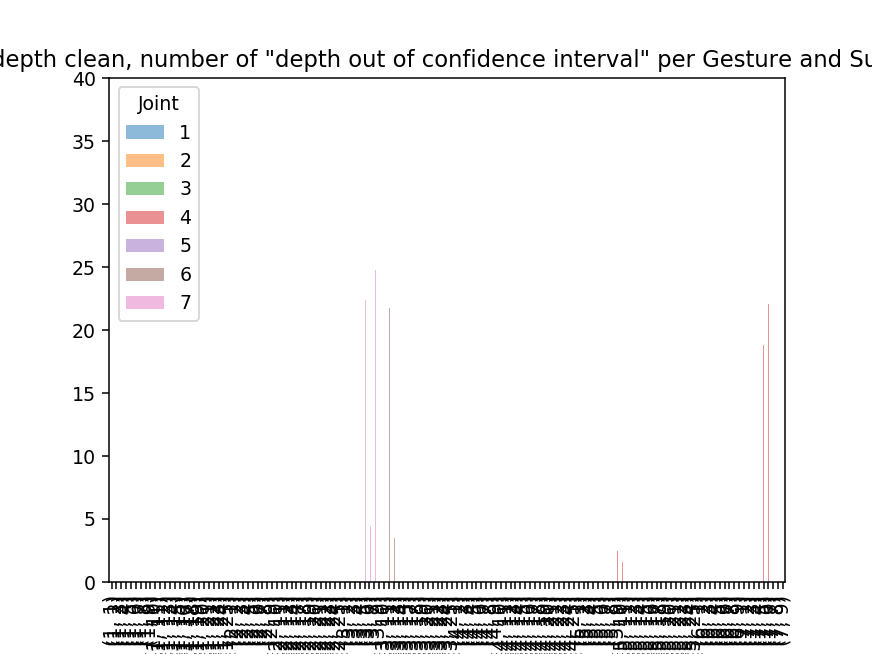

In [67]:
keypoints_1_7_depth_cleaned.pivot_table(index = ['Gesture', 'Sub folder No.'], columns = ['Joint'], values = 'Depth-Depth_median', aggfunc = lambda x: np.count_nonzero(np.logical_or(x<confidence_interval_left, x>confidence_interval_right))/len(x)*100).plot.bar(title='After depth clean, number of \"depth out of confidence interval\" per Gesture and Sub folder', legend=True, alpha=0.5, yticks=np.arange(0, 45, 5))

#### After depth clean, recheck the depth data of one joint (Joint 4 for example) of all gestures, we can see the depth values are much smoother, abnormal values (noises) have been cleaned

<IPython.core.display.Javascript object>


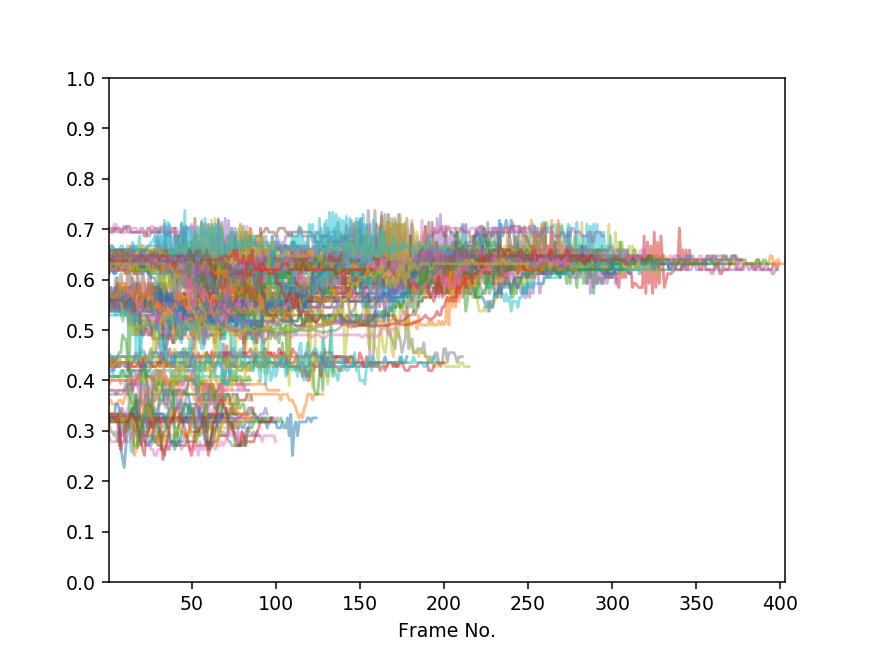

In [68]:
keypoints_1_7_depth_cleaned[np.logical_and(keypoints_1_7_depth_cleaned['Joint']==4, keypoints_1_7_depth_cleaned['Gesture']<8)].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='Depth').plot.line(alpha=0.5, legend=False, yticks=np.arange(0, 1.1, 0.1))

#### Keep the cleaned depth, and remove the columns used for depth cleaning

In [69]:
keypoints_1_7_cleaned = keypoints_1_7_depth_cleaned.copy()
new_columns = ['Gesture', 'Sub folder No.', 'Frame No.', 'Joint', 'X', 'Y', 'Depth']
keypoints_1_7_cleaned = keypoints_1_7_cleaned.reindex(columns = new_columns)
keypoints_1_7_cleaned.head()

,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Depth
1,1,1,1,1,650.893982,268.933197,0.352941
2,1,1,1,2,576.504761,270.824951,0.360784
3,1,1,1,3,556.990112,382.489716,0.360784
4,1,1,1,4,554.818665,494.189514,0.325490
5,1,1,1,5,723.442871,266.960022,0.372549


## Step 4: Data normalization

In [70]:
Keypoints_1_7_normalized = keypoints_1_7_cleaned.copy()
Keypoints_1_7_normalized['X'] = keypoints_1_7_cleaned['X']/1280
Keypoints_1_7_normalized['Y'] = keypoints_1_7_cleaned['Y']/720
Keypoints_1_7_normalized.head(7)

,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Depth
1,1,1,1,1,0.508511,0.373518,0.352941
2,1,1,1,2,0.450394,0.376146,0.360784
3,1,1,1,3,0.435149,0.531236,0.360784
4,1,1,1,4,0.433452,0.686374,0.325490
5,1,1,1,5,0.565190,0.370778,0.372549
6,1,1,1,6,0.582080,0.520458,0.333333
7,1,1,1,7,0.594220,0.683699,0.317647


In [71]:
Keypoints_1_7_normalized.to_json('Keypoints_1_7_normalized_Ayosh&New.json', orient='records')